# RNN手动实现

实现RNN预测股价，主要分为以下几个部分：  
1、数据集载入   
2、RNN类实现  
3、训练函数实现  

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pandas as pd
import torch
import akshare as ak
import numpy as np
import matplotlib.pyplot as plt
import random

利用akshare数据库导入股票数据

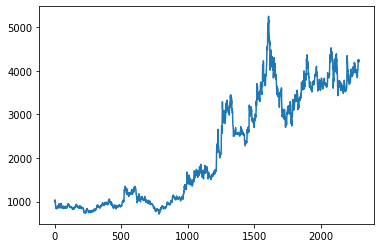

In [17]:
import akshare as ak
data = ak.stock_zh_a_daily(symbol="sz000002", start_date="20101103", end_date="20201116", adjust="hfq")
plt.plot(data.open)

In [19]:
# 考虑加入换手率、成交量、涨跌幅等因素
std = data.std()
mean = data.mean()
data["open"] = data.open - mean.open
data["volume"] = (data.volume - mean.volume) / std.volume
data["turnover"] = (data.turnover - mean.turnover) / std.turnover
data = data.loc[:, ["open", "volume", "turnover"]]
data.head()

,open,volume,turnover
0,-1183.126981,0.609411,0.616826
1,-1162.286981,0.163150,0.168099
2,-1149.776981,0.438174,0.444643
3,-1164.366981,0.791633,0.800056
4,-1157.076981,1.070053,1.080014


载入数据集和数据迭代器

In [27]:
def random_data_iter(seq, batch_size, seq_len):
    # 首先要确定起始位置
    seq = seq[random.randint(0, seq_len):]
    # 其次确定序列总数
    num_seq = (len(seq)-1) // seq_len
    # 找到所有子序列起始位置
    init_indexs = list(range(0, num_seq*seq_len, seq_len))
    # 打乱
    random.shuffle(init_indexs)
    
    def _data(index):
        return seq[index:index+seq_len]
    
    # 计算batch数量
    num_batches = num_seq // batch_size
    for i in range(0, num_batches*batch_size, batch_size):
        indice = init_indexs[i:i+batch_size]
        X = [_data(j) for j in indice]
        Y = [_data(j+1) for j in indice]
        yield torch.tensor(X).reshape((batch_size,seq_len,3)), torch.tensor(Y).reshape((batch_size,seq_len,3))

In [28]:
# 建立数据迭代类，来满足不同epoch的训练
class SeqIter:
    def __init__(self, seq, batch_size, seq_len):
        self.seq = seq.values
        self.batch_size = batch_size
        self.seq_len = seq_len
    
    def __iter__(self):
        return random_data_iter(self.seq, self.batch_size, self.seq_len)

RNN类实现

In [29]:
def get_param(input_dim, output_dim, hidden_dim, device):
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    
    # 分别创建 W_hx, W_hh, b_h, W_hq, h_q
    W_hx = normal((input_dim ,hidden_dim))
    W_hh = normal((hidden_dim, hidden_dim))
    b_h = torch.zeros(hidden_dim, device=device)
    W_hq = normal((hidden_dim, output_dim))
    b_q = torch.zeros(output_dim, device=device)
    
    params = [W_hx, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
        
    return params
        

In [30]:
def rnn(X, params, state):
    # 获取参数
    W_hx, W_hh, b_h, W_hq, b_q = params
    H, = state
    
    #更改X的w维度
    X = X.permute(1, 0, 2)
    
    outputs = []
    # 计算并返回
    for x in X:
        H = torch.relu(torch.matmul(x, W_hx) + torch.matmul(H, W_hh) + b_h)
        o = (torch.matmul(H, W_hq) + b_q)
        outputs.append(o.reshape((-1, o.shape[0], 3)))
    return torch.cat(outputs, dim=0).permute(1, 0, 2).squeeze(2), (H, )

In [31]:
def init_state(batch_size, hidden_dim):
    return torch.zeros((batch_size, hidden_dim))

In [32]:
class MyRNN:
    def __init__(self, input_dim, output_dim, batch_size, hidden_dim, init_state, forward_fn, get_param, device=torch.device('cpu')):
        #传入相关参数：input_dim, batch_size, hidden_dim, init_state, forward_fn, 
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.init_state = init_state
        self.forward_fn = forward_fn
        self.device = device
        #创建权重
        self.params = get_param(input_dim, output_dim, hidden_dim, device)
    
    def __call__(self, X, state):
        return self.forward_fn(X, self.params, state)
    
    def begin_state(self):
        return (init_state(self.batch_size, self.hidden_dim), )

测试一下输入输出

In [34]:
net = MyRNN(3, 3, 64, 10, init_state, rnn, get_param)
state = net.begin_state()
for X, Y in SeqIter(data, 64, 20):
    state = net.begin_state()
    y_hat, state = net(X.float(), state)
    print(Y.reshape(-1).float())
    break

tensor([-5.9843e+02, -2.4136e-01, -2.4344e-01,  ..., -9.6399e+02,
        -2.0901e-01, -2.0750e-01])


训练函数实现

In [79]:
def grad_clipping(net, theta):
    params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [80]:
def train_epoch(net, train_iter, loss, updater, device):
    total_loss = 0
    for X, Y in train_iter(data, 64, 5):
        # 初始化
        state = net.begin_state()
        y_real = Y.reshape(-1).float()
        X, y_real = X.float(), y_real.float()
        
        y_hat, state = net(X, state)
        y_hat = y_hat.reshape(-1).float()
        l = loss(y_real, y_hat).mean()
        print(l)
        l.backward()
        grad_clipping(net, 1)
        updater(1)
        total_loss += l
    return total_loss

In [81]:
def backward_fn(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param[:] = param - lr * param.grad / batch_size
            param.grad.zero_()

In [82]:
def train(net, train_iter, epoches, lr,  device=torch.device('cpu')):
    loss = torch.nn.MSELoss()
    updater = lambda batch_size: backward_fn(net.params, lr, batch_size)
    
    for epoch in range(epoches):
        total_loss = train_epoch(net, train_iter, loss, updater, device)
        if (epoch + 1) % 10 == 0:
            print(f'第{epoch+1}次训练，损失：{total_loss}')

In [83]:
net = MyRNN(3, 3, 64, 100, init_state, rnn, get_param)
train(net, SeqIter, 1000, 0.003)

tensor(535791.4375, grad_fn=<MeanBackward0>)
tensor(520366.5938, grad_fn=<MeanBackward0>)
tensor(517803.2812, grad_fn=<MeanBackward0>)
tensor(570463.2500, grad_fn=<MeanBackward0>)
tensor(490773.0625, grad_fn=<MeanBackward0>)
tensor(569802.1875, grad_fn=<MeanBackward0>)
tensor(539622.9375, grad_fn=<MeanBackward0>)
tensor(514992.5312, grad_fn=<MeanBackward0>)
tensor(509444., grad_fn=<MeanBackward0>)
tensor(554414.5000, grad_fn=<MeanBackward0>)
tensor(490802.4375, grad_fn=<MeanBackward0>)
tensor(578508., grad_fn=<MeanBackward0>)
tensor(544178.7500, grad_fn=<MeanBackward0>)
tensor(529878.3750, grad_fn=<MeanBackward0>)
tensor(627523.4375, grad_fn=<MeanBackward0>)
tensor(561671.3750, grad_fn=<MeanBackward0>)
tensor(523060.9375, grad_fn=<MeanBackward0>)
tensor(464753.2812, grad_fn=<MeanBackward0>)
tensor(558880.0625, grad_fn=<MeanBackward0>)
tensor(511718.9062, grad_fn=<MeanBackward0>)
tensor(493061.8125, grad_fn=<MeanBackward0>)
tensor(544777.6250, grad_fn=<MeanBackward0>)
tensor(504790.2188

tensor(399140.2812, grad_fn=<MeanBackward0>)
tensor(382000.6250, grad_fn=<MeanBackward0>)
tensor(468892.6562, grad_fn=<MeanBackward0>)
tensor(437098.0312, grad_fn=<MeanBackward0>)
tensor(398878., grad_fn=<MeanBackward0>)
tensor(416532.9375, grad_fn=<MeanBackward0>)
tensor(499053.8438, grad_fn=<MeanBackward0>)
tensor(383031.7188, grad_fn=<MeanBackward0>)
tensor(403110.6250, grad_fn=<MeanBackward0>)
tensor(436802.9375, grad_fn=<MeanBackward0>)
tensor(410244.8750, grad_fn=<MeanBackward0>)
tensor(416206.5938, grad_fn=<MeanBackward0>)
tensor(421567.1250, grad_fn=<MeanBackward0>)
tensor(417314.8438, grad_fn=<MeanBackward0>)
tensor(431976.9062, grad_fn=<MeanBackward0>)
tensor(383710.2812, grad_fn=<MeanBackward0>)
tensor(426279.7812, grad_fn=<MeanBackward0>)
tensor(383530.6250, grad_fn=<MeanBackward0>)
tensor(393772.0938, grad_fn=<MeanBackward0>)
tensor(359528.4688, grad_fn=<MeanBackward0>)
tensor(419724., grad_fn=<MeanBackward0>)
tensor(387022.4062, grad_fn=<MeanBackward0>)
tensor(390891.8125

tensor(224290.4062, grad_fn=<MeanBackward0>)
tensor(187486.6094, grad_fn=<MeanBackward0>)
tensor(203636.2031, grad_fn=<MeanBackward0>)
tensor(202521.5625, grad_fn=<MeanBackward0>)
tensor(191984.8906, grad_fn=<MeanBackward0>)
tensor(214349.5156, grad_fn=<MeanBackward0>)
tensor(216550.1562, grad_fn=<MeanBackward0>)
tensor(205429.6094, grad_fn=<MeanBackward0>)
tensor(209878.8281, grad_fn=<MeanBackward0>)
tensor(180607.2500, grad_fn=<MeanBackward0>)
tensor(202515.2031, grad_fn=<MeanBackward0>)
tensor(209043.9219, grad_fn=<MeanBackward0>)
tensor(208629.3125, grad_fn=<MeanBackward0>)
tensor(201256.2031, grad_fn=<MeanBackward0>)
tensor(181873.9844, grad_fn=<MeanBackward0>)
tensor(193537.5469, grad_fn=<MeanBackward0>)
tensor(163348.4375, grad_fn=<MeanBackward0>)
tensor(196616.7500, grad_fn=<MeanBackward0>)
tensor(207817.8281, grad_fn=<MeanBackward0>)
tensor(197274.8125, grad_fn=<MeanBackward0>)
tensor(200688.1406, grad_fn=<MeanBackward0>)
tensor(179040.5781, grad_fn=<MeanBackward0>)
tensor(159

tensor(33422.4180, grad_fn=<MeanBackward0>)
tensor(36697.9805, grad_fn=<MeanBackward0>)
tensor(38723.1094, grad_fn=<MeanBackward0>)
tensor(37285.1602, grad_fn=<MeanBackward0>)
tensor(29955.3672, grad_fn=<MeanBackward0>)
tensor(29082.0547, grad_fn=<MeanBackward0>)
tensor(31008.2363, grad_fn=<MeanBackward0>)
tensor(29874.6016, grad_fn=<MeanBackward0>)
tensor(29654.2617, grad_fn=<MeanBackward0>)
第80次训练，损失：225582.796875
tensor(29497.3418, grad_fn=<MeanBackward0>)
tensor(25508.8301, grad_fn=<MeanBackward0>)
tensor(24415.8672, grad_fn=<MeanBackward0>)
tensor(30104.8633, grad_fn=<MeanBackward0>)
tensor(31283.1543, grad_fn=<MeanBackward0>)
tensor(26724.6328, grad_fn=<MeanBackward0>)
tensor(25534.5215, grad_fn=<MeanBackward0>)
tensor(28873.5117, grad_fn=<MeanBackward0>)
tensor(22973.1895, grad_fn=<MeanBackward0>)
tensor(22529.6074, grad_fn=<MeanBackward0>)
tensor(24930.8516, grad_fn=<MeanBackward0>)
tensor(24367.0605, grad_fn=<MeanBackward0>)
tensor(20484.0234, grad_fn=<MeanBackward0>)
tensor(2

tensor(2074.2061, grad_fn=<MeanBackward0>)
tensor(1455.0938, grad_fn=<MeanBackward0>)
tensor(1263.3579, grad_fn=<MeanBackward0>)
tensor(1286.3065, grad_fn=<MeanBackward0>)
tensor(1289.6057, grad_fn=<MeanBackward0>)
tensor(813.6603, grad_fn=<MeanBackward0>)
tensor(1197.2229, grad_fn=<MeanBackward0>)
tensor(1344.5310, grad_fn=<MeanBackward0>)
tensor(1468.2511, grad_fn=<MeanBackward0>)
tensor(1013.9423, grad_fn=<MeanBackward0>)
tensor(1217.1583, grad_fn=<MeanBackward0>)
tensor(1438.0396, grad_fn=<MeanBackward0>)
tensor(1339.0298, grad_fn=<MeanBackward0>)
tensor(1053.2787, grad_fn=<MeanBackward0>)
tensor(1056.6802, grad_fn=<MeanBackward0>)
tensor(1000.9578, grad_fn=<MeanBackward0>)
tensor(1212.8912, grad_fn=<MeanBackward0>)
tensor(1387.4321, grad_fn=<MeanBackward0>)
tensor(1909.9629, grad_fn=<MeanBackward0>)
tensor(1330.7036, grad_fn=<MeanBackward0>)
tensor(1191.1605, grad_fn=<MeanBackward0>)
tensor(1365.4924, grad_fn=<MeanBackward0>)
tensor(1428.0930, grad_fn=<MeanBackward0>)
tensor(614.3

tensor(1418.6882, grad_fn=<MeanBackward0>)
tensor(968.0007, grad_fn=<MeanBackward0>)
tensor(1706.1758, grad_fn=<MeanBackward0>)
tensor(916.3824, grad_fn=<MeanBackward0>)
tensor(1343.8948, grad_fn=<MeanBackward0>)
tensor(974.8151, grad_fn=<MeanBackward0>)
tensor(1608.3700, grad_fn=<MeanBackward0>)
tensor(931.9947, grad_fn=<MeanBackward0>)
tensor(1206.0516, grad_fn=<MeanBackward0>)
tensor(1054.5781, grad_fn=<MeanBackward0>)
tensor(1989.7893, grad_fn=<MeanBackward0>)
tensor(1459.6010, grad_fn=<MeanBackward0>)
tensor(1243.8566, grad_fn=<MeanBackward0>)
tensor(895.6218, grad_fn=<MeanBackward0>)
tensor(1235.8596, grad_fn=<MeanBackward0>)
tensor(1267.8086, grad_fn=<MeanBackward0>)
tensor(1321.4349, grad_fn=<MeanBackward0>)
tensor(1319.7736, grad_fn=<MeanBackward0>)
tensor(861.4057, grad_fn=<MeanBackward0>)
tensor(1657.3085, grad_fn=<MeanBackward0>)
tensor(1235.3268, grad_fn=<MeanBackward0>)
tensor(1418.0651, grad_fn=<MeanBackward0>)
tensor(957.0982, grad_fn=<MeanBackward0>)
tensor(882.7254, g

tensor(1141.9266, grad_fn=<MeanBackward0>)
tensor(1765.2583, grad_fn=<MeanBackward0>)
tensor(1217.4198, grad_fn=<MeanBackward0>)
tensor(1186.0698, grad_fn=<MeanBackward0>)
tensor(1017.0621, grad_fn=<MeanBackward0>)
tensor(1512.8628, grad_fn=<MeanBackward0>)
第180次训练，损失：8944.966796875
tensor(971.4809, grad_fn=<MeanBackward0>)
tensor(1272.0027, grad_fn=<MeanBackward0>)
tensor(1489.9916, grad_fn=<MeanBackward0>)
tensor(1016.7276, grad_fn=<MeanBackward0>)
tensor(1581.9125, grad_fn=<MeanBackward0>)
tensor(1161.3003, grad_fn=<MeanBackward0>)
tensor(1246.6121, grad_fn=<MeanBackward0>)
tensor(1689.5663, grad_fn=<MeanBackward0>)
tensor(1241.4890, grad_fn=<MeanBackward0>)
tensor(924.6559, grad_fn=<MeanBackward0>)
tensor(1233.5156, grad_fn=<MeanBackward0>)
tensor(1010.7149, grad_fn=<MeanBackward0>)
tensor(1272.0190, grad_fn=<MeanBackward0>)
tensor(1530.3099, grad_fn=<MeanBackward0>)
tensor(1660.9282, grad_fn=<MeanBackward0>)
tensor(1356.9515, grad_fn=<MeanBackward0>)
tensor(996.8203, grad_fn=<Mean

tensor(1196.6199, grad_fn=<MeanBackward0>)
tensor(1616.6105, grad_fn=<MeanBackward0>)
tensor(1512.9292, grad_fn=<MeanBackward0>)
tensor(1408.3984, grad_fn=<MeanBackward0>)
tensor(1013.3334, grad_fn=<MeanBackward0>)
tensor(1510.5942, grad_fn=<MeanBackward0>)
tensor(1048.7162, grad_fn=<MeanBackward0>)
tensor(1186.6707, grad_fn=<MeanBackward0>)
tensor(1165.8224, grad_fn=<MeanBackward0>)
tensor(1226.6232, grad_fn=<MeanBackward0>)
tensor(1839.5269, grad_fn=<MeanBackward0>)
tensor(1476.3641, grad_fn=<MeanBackward0>)
tensor(1205.0287, grad_fn=<MeanBackward0>)
tensor(1255.8021, grad_fn=<MeanBackward0>)
tensor(1297.6901, grad_fn=<MeanBackward0>)
tensor(1251.7626, grad_fn=<MeanBackward0>)
tensor(1005.2861, grad_fn=<MeanBackward0>)
tensor(1392.7562, grad_fn=<MeanBackward0>)
tensor(872.8245, grad_fn=<MeanBackward0>)
tensor(1752.5154, grad_fn=<MeanBackward0>)
tensor(1371.4896, grad_fn=<MeanBackward0>)
tensor(1070.0555, grad_fn=<MeanBackward0>)
tensor(1399.2095, grad_fn=<MeanBackward0>)
tensor(1266.

tensor(967.6185, grad_fn=<MeanBackward0>)
tensor(981.0445, grad_fn=<MeanBackward0>)
tensor(1309.2035, grad_fn=<MeanBackward0>)
tensor(1053.0729, grad_fn=<MeanBackward0>)
tensor(1057.7833, grad_fn=<MeanBackward0>)
tensor(1655.7902, grad_fn=<MeanBackward0>)
tensor(1428.0800, grad_fn=<MeanBackward0>)
tensor(1302.4414, grad_fn=<MeanBackward0>)
tensor(1140.3398, grad_fn=<MeanBackward0>)
tensor(1290.1740, grad_fn=<MeanBackward0>)
tensor(1521.5325, grad_fn=<MeanBackward0>)
tensor(1334.7380, grad_fn=<MeanBackward0>)
tensor(1270.1838, grad_fn=<MeanBackward0>)
tensor(1238.9532, grad_fn=<MeanBackward0>)
tensor(1142.1641, grad_fn=<MeanBackward0>)
tensor(1208.3287, grad_fn=<MeanBackward0>)
tensor(950.5789, grad_fn=<MeanBackward0>)
tensor(1062.6259, grad_fn=<MeanBackward0>)
tensor(1131.6484, grad_fn=<MeanBackward0>)
tensor(1838.5667, grad_fn=<MeanBackward0>)
tensor(1360.2659, grad_fn=<MeanBackward0>)
tensor(1454.9556, grad_fn=<MeanBackward0>)
tensor(1410.1399, grad_fn=<MeanBackward0>)
tensor(974.467

tensor(975.5246, grad_fn=<MeanBackward0>)
tensor(1057.4586, grad_fn=<MeanBackward0>)
tensor(1845.1482, grad_fn=<MeanBackward0>)
tensor(811.6006, grad_fn=<MeanBackward0>)
tensor(1220.1987, grad_fn=<MeanBackward0>)
tensor(1023.5348, grad_fn=<MeanBackward0>)
tensor(1490.3258, grad_fn=<MeanBackward0>)
tensor(1519.7500, grad_fn=<MeanBackward0>)
tensor(1211.9479, grad_fn=<MeanBackward0>)
tensor(1241.0304, grad_fn=<MeanBackward0>)
tensor(841.7677, grad_fn=<MeanBackward0>)
tensor(1223.2296, grad_fn=<MeanBackward0>)
tensor(1013.4490, grad_fn=<MeanBackward0>)
tensor(1469.6422, grad_fn=<MeanBackward0>)
tensor(1159.9796, grad_fn=<MeanBackward0>)
tensor(1033.9888, grad_fn=<MeanBackward0>)
tensor(1649.4995, grad_fn=<MeanBackward0>)
tensor(1391.8859, grad_fn=<MeanBackward0>)
tensor(1235.3933, grad_fn=<MeanBackward0>)
tensor(1379.8418, grad_fn=<MeanBackward0>)
tensor(1531.8789, grad_fn=<MeanBackward0>)
tensor(891.6765, grad_fn=<MeanBackward0>)
tensor(903.3510, grad_fn=<MeanBackward0>)
tensor(1142.2136

tensor(1148.9321, grad_fn=<MeanBackward0>)
tensor(1190.7261, grad_fn=<MeanBackward0>)
tensor(938.5335, grad_fn=<MeanBackward0>)
tensor(1418.3568, grad_fn=<MeanBackward0>)
tensor(1269.1571, grad_fn=<MeanBackward0>)
tensor(1521.7773, grad_fn=<MeanBackward0>)
tensor(1094.4810, grad_fn=<MeanBackward0>)
tensor(1350.1110, grad_fn=<MeanBackward0>)
tensor(1257.5197, grad_fn=<MeanBackward0>)
tensor(1418.0304, grad_fn=<MeanBackward0>)
tensor(1527.4027, grad_fn=<MeanBackward0>)
tensor(894.0450, grad_fn=<MeanBackward0>)
tensor(1337.4059, grad_fn=<MeanBackward0>)
tensor(1208.2026, grad_fn=<MeanBackward0>)
tensor(1280.7144, grad_fn=<MeanBackward0>)
tensor(1314.6907, grad_fn=<MeanBackward0>)
tensor(990.1057, grad_fn=<MeanBackward0>)
tensor(977.7167, grad_fn=<MeanBackward0>)
tensor(1464.1333, grad_fn=<MeanBackward0>)
tensor(1350.3185, grad_fn=<MeanBackward0>)
tensor(1532.8359, grad_fn=<MeanBackward0>)
tensor(1147.1949, grad_fn=<MeanBackward0>)
tensor(911.9643, grad_fn=<MeanBackward0>)
tensor(1356.3606

tensor(814.4638, grad_fn=<MeanBackward0>)
tensor(1547.2389, grad_fn=<MeanBackward0>)
tensor(1176.4672, grad_fn=<MeanBackward0>)
tensor(1852.0118, grad_fn=<MeanBackward0>)
tensor(890.8891, grad_fn=<MeanBackward0>)
tensor(1508.5059, grad_fn=<MeanBackward0>)
tensor(1028.8451, grad_fn=<MeanBackward0>)
tensor(1317.2279, grad_fn=<MeanBackward0>)
tensor(1719.7814, grad_fn=<MeanBackward0>)
tensor(1274.9336, grad_fn=<MeanBackward0>)
tensor(1165.9878, grad_fn=<MeanBackward0>)
tensor(1124.6882, grad_fn=<MeanBackward0>)
tensor(913.1179, grad_fn=<MeanBackward0>)
tensor(1351.0718, grad_fn=<MeanBackward0>)
tensor(916.7545, grad_fn=<MeanBackward0>)
tensor(1163.3282, grad_fn=<MeanBackward0>)
tensor(1243.5677, grad_fn=<MeanBackward0>)
tensor(1277.7039, grad_fn=<MeanBackward0>)
tensor(909.9491, grad_fn=<MeanBackward0>)
tensor(1134.8652, grad_fn=<MeanBackward0>)
tensor(2013.4679, grad_fn=<MeanBackward0>)
tensor(1705.7277, grad_fn=<MeanBackward0>)
tensor(1564.8169, grad_fn=<MeanBackward0>)
tensor(1134.1464

tensor(1603.4235, grad_fn=<MeanBackward0>)
tensor(846.1479, grad_fn=<MeanBackward0>)
tensor(1063.0042, grad_fn=<MeanBackward0>)
tensor(1382.5297, grad_fn=<MeanBackward0>)
tensor(1224.0007, grad_fn=<MeanBackward0>)
tensor(1360.7137, grad_fn=<MeanBackward0>)
tensor(1047.1785, grad_fn=<MeanBackward0>)
tensor(1127.8794, grad_fn=<MeanBackward0>)
tensor(1617.2385, grad_fn=<MeanBackward0>)
tensor(1209.6720, grad_fn=<MeanBackward0>)
tensor(1133.7257, grad_fn=<MeanBackward0>)
tensor(1160.8695, grad_fn=<MeanBackward0>)
tensor(1452.2804, grad_fn=<MeanBackward0>)
tensor(1301.5210, grad_fn=<MeanBackward0>)
tensor(1499.9176, grad_fn=<MeanBackward0>)
tensor(1105.4402, grad_fn=<MeanBackward0>)
tensor(1249.5669, grad_fn=<MeanBackward0>)
tensor(1372.7229, grad_fn=<MeanBackward0>)
tensor(1108.5349, grad_fn=<MeanBackward0>)
tensor(1015.3301, grad_fn=<MeanBackward0>)
tensor(1401.3722, grad_fn=<MeanBackward0>)
tensor(1646.1239, grad_fn=<MeanBackward0>)
tensor(1064.6720, grad_fn=<MeanBackward0>)
tensor(1038.

tensor(1142.9152, grad_fn=<MeanBackward0>)
tensor(1252.7811, grad_fn=<MeanBackward0>)
tensor(1304.1116, grad_fn=<MeanBackward0>)
tensor(1407.4583, grad_fn=<MeanBackward0>)
tensor(1247.7356, grad_fn=<MeanBackward0>)
tensor(945.9169, grad_fn=<MeanBackward0>)
tensor(1461.5044, grad_fn=<MeanBackward0>)
tensor(1147.4086, grad_fn=<MeanBackward0>)
tensor(1088.2693, grad_fn=<MeanBackward0>)
tensor(1235.7086, grad_fn=<MeanBackward0>)
tensor(1245.0585, grad_fn=<MeanBackward0>)
tensor(900.1557, grad_fn=<MeanBackward0>)
tensor(1685.0651, grad_fn=<MeanBackward0>)
tensor(1120.4442, grad_fn=<MeanBackward0>)
tensor(1466.4530, grad_fn=<MeanBackward0>)
tensor(1780.5511, grad_fn=<MeanBackward0>)
tensor(1366.2097, grad_fn=<MeanBackward0>)
tensor(1275.0491, grad_fn=<MeanBackward0>)
tensor(1262.5690, grad_fn=<MeanBackward0>)
tensor(1079.5925, grad_fn=<MeanBackward0>)
tensor(1050.5156, grad_fn=<MeanBackward0>)
tensor(1071.6820, grad_fn=<MeanBackward0>)
tensor(1155.8273, grad_fn=<MeanBackward0>)
tensor(925.47

tensor(958.9376, grad_fn=<MeanBackward0>)
tensor(1653.5570, grad_fn=<MeanBackward0>)
tensor(1021.5592, grad_fn=<MeanBackward0>)
tensor(1531.3853, grad_fn=<MeanBackward0>)
tensor(1296.8177, grad_fn=<MeanBackward0>)
tensor(1430.1333, grad_fn=<MeanBackward0>)
tensor(896.0543, grad_fn=<MeanBackward0>)
第450次训练，损失：8788.4443359375
tensor(1720.1721, grad_fn=<MeanBackward0>)
tensor(1497.6622, grad_fn=<MeanBackward0>)
tensor(1218.1381, grad_fn=<MeanBackward0>)
tensor(832.4590, grad_fn=<MeanBackward0>)
tensor(1272.0149, grad_fn=<MeanBackward0>)
tensor(1045.5485, grad_fn=<MeanBackward0>)
tensor(1349.4718, grad_fn=<MeanBackward0>)
tensor(803.8539, grad_fn=<MeanBackward0>)
tensor(1285.7388, grad_fn=<MeanBackward0>)
tensor(1189.2745, grad_fn=<MeanBackward0>)
tensor(1876.2532, grad_fn=<MeanBackward0>)
tensor(1409.6528, grad_fn=<MeanBackward0>)
tensor(1425.1704, grad_fn=<MeanBackward0>)
tensor(929.2223, grad_fn=<MeanBackward0>)
tensor(1092.4723, grad_fn=<MeanBackward0>)
tensor(1416.6141, grad_fn=<MeanB

tensor(1374.7688, grad_fn=<MeanBackward0>)
tensor(952.4190, grad_fn=<MeanBackward0>)
tensor(1627.0652, grad_fn=<MeanBackward0>)
tensor(1116.6487, grad_fn=<MeanBackward0>)
tensor(1274.4122, grad_fn=<MeanBackward0>)
tensor(1373.5214, grad_fn=<MeanBackward0>)
tensor(1121.3239, grad_fn=<MeanBackward0>)
tensor(1557.2469, grad_fn=<MeanBackward0>)
tensor(1080.4242, grad_fn=<MeanBackward0>)
tensor(1451.4574, grad_fn=<MeanBackward0>)
tensor(919.3455, grad_fn=<MeanBackward0>)
tensor(1343.9032, grad_fn=<MeanBackward0>)
tensor(1115.4800, grad_fn=<MeanBackward0>)
tensor(1325.1073, grad_fn=<MeanBackward0>)
tensor(1781.9884, grad_fn=<MeanBackward0>)
tensor(1112.8441, grad_fn=<MeanBackward0>)
tensor(1173.4071, grad_fn=<MeanBackward0>)
tensor(1358.3990, grad_fn=<MeanBackward0>)
tensor(944.2297, grad_fn=<MeanBackward0>)
tensor(1173.1243, grad_fn=<MeanBackward0>)
tensor(1329.8580, grad_fn=<MeanBackward0>)
tensor(1744.9291, grad_fn=<MeanBackward0>)
tensor(661.9218, grad_fn=<MeanBackward0>)
tensor(1173.041

tensor(1793.3234, grad_fn=<MeanBackward0>)
tensor(1330.0698, grad_fn=<MeanBackward0>)
tensor(996.7384, grad_fn=<MeanBackward0>)
tensor(1343.7889, grad_fn=<MeanBackward0>)
tensor(1180.1191, grad_fn=<MeanBackward0>)
tensor(1197.4659, grad_fn=<MeanBackward0>)
tensor(1262.3705, grad_fn=<MeanBackward0>)
tensor(1249.9861, grad_fn=<MeanBackward0>)
tensor(1521.0391, grad_fn=<MeanBackward0>)
tensor(1501.6836, grad_fn=<MeanBackward0>)
tensor(1082.4371, grad_fn=<MeanBackward0>)
tensor(1148.2188, grad_fn=<MeanBackward0>)
tensor(1284.1888, grad_fn=<MeanBackward0>)
tensor(835.0461, grad_fn=<MeanBackward0>)
tensor(1336.6838, grad_fn=<MeanBackward0>)
tensor(1179.4139, grad_fn=<MeanBackward0>)
tensor(1818.5964, grad_fn=<MeanBackward0>)
tensor(1205.9478, grad_fn=<MeanBackward0>)
tensor(1546.7524, grad_fn=<MeanBackward0>)
tensor(1265.9028, grad_fn=<MeanBackward0>)
tensor(1058.7560, grad_fn=<MeanBackward0>)
tensor(1413.4576, grad_fn=<MeanBackward0>)
tensor(1255.8416, grad_fn=<MeanBackward0>)
tensor(1134.4

tensor(1766.5680, grad_fn=<MeanBackward0>)
tensor(1456.4918, grad_fn=<MeanBackward0>)
tensor(1077.3397, grad_fn=<MeanBackward0>)
tensor(1294.0122, grad_fn=<MeanBackward0>)
tensor(1564.0337, grad_fn=<MeanBackward0>)
tensor(1112.1311, grad_fn=<MeanBackward0>)
tensor(1702.5151, grad_fn=<MeanBackward0>)
tensor(1133.6660, grad_fn=<MeanBackward0>)
tensor(936.4889, grad_fn=<MeanBackward0>)
tensor(1191.2507, grad_fn=<MeanBackward0>)
tensor(1216.1534, grad_fn=<MeanBackward0>)
tensor(1452.2875, grad_fn=<MeanBackward0>)
tensor(1244.6077, grad_fn=<MeanBackward0>)
tensor(1108.7559, grad_fn=<MeanBackward0>)
tensor(1383.3051, grad_fn=<MeanBackward0>)
tensor(1287.0277, grad_fn=<MeanBackward0>)
第540次训练，损失：8883.388671875
tensor(1044.4357, grad_fn=<MeanBackward0>)
tensor(1445.8358, grad_fn=<MeanBackward0>)
tensor(1059.5916, grad_fn=<MeanBackward0>)
tensor(744.5555, grad_fn=<MeanBackward0>)
tensor(1106.8586, grad_fn=<MeanBackward0>)
tensor(1667.7039, grad_fn=<MeanBackward0>)
tensor(1638.8577, grad_fn=<Mea

tensor(1399.4773, grad_fn=<MeanBackward0>)
tensor(1513.7396, grad_fn=<MeanBackward0>)
tensor(1378.9059, grad_fn=<MeanBackward0>)
tensor(1428.9520, grad_fn=<MeanBackward0>)
tensor(939.7920, grad_fn=<MeanBackward0>)
tensor(1191.8420, grad_fn=<MeanBackward0>)
tensor(1105.8379, grad_fn=<MeanBackward0>)
tensor(1052.7134, grad_fn=<MeanBackward0>)
tensor(1083.0923, grad_fn=<MeanBackward0>)
tensor(1138.8668, grad_fn=<MeanBackward0>)
tensor(1521.0718, grad_fn=<MeanBackward0>)
tensor(1510.4510, grad_fn=<MeanBackward0>)
tensor(1392.9652, grad_fn=<MeanBackward0>)
tensor(1145.8644, grad_fn=<MeanBackward0>)
tensor(982.3271, grad_fn=<MeanBackward0>)
tensor(1260.2800, grad_fn=<MeanBackward0>)
tensor(983.3034, grad_fn=<MeanBackward0>)
tensor(1141.2651, grad_fn=<MeanBackward0>)
tensor(1785.0851, grad_fn=<MeanBackward0>)
tensor(1003.3080, grad_fn=<MeanBackward0>)
tensor(1629.3304, grad_fn=<MeanBackward0>)
tensor(1274.9983, grad_fn=<MeanBackward0>)
tensor(1742.6401, grad_fn=<MeanBackward0>)
tensor(1023.43

tensor(1374.9384, grad_fn=<MeanBackward0>)
tensor(1152.2156, grad_fn=<MeanBackward0>)
tensor(1033.8385, grad_fn=<MeanBackward0>)
tensor(1044.6251, grad_fn=<MeanBackward0>)
tensor(1869.2448, grad_fn=<MeanBackward0>)
tensor(1286.2679, grad_fn=<MeanBackward0>)
tensor(993.2789, grad_fn=<MeanBackward0>)
tensor(1514.0988, grad_fn=<MeanBackward0>)
tensor(1367.0112, grad_fn=<MeanBackward0>)
tensor(1290.7971, grad_fn=<MeanBackward0>)
tensor(1197.5151, grad_fn=<MeanBackward0>)
tensor(1277.7063, grad_fn=<MeanBackward0>)
tensor(1252.3872, grad_fn=<MeanBackward0>)
tensor(1090.8005, grad_fn=<MeanBackward0>)
tensor(1185.6311, grad_fn=<MeanBackward0>)
tensor(1394.7056, grad_fn=<MeanBackward0>)
tensor(1217.9027, grad_fn=<MeanBackward0>)
tensor(1058.5806, grad_fn=<MeanBackward0>)
tensor(1760.0413, grad_fn=<MeanBackward0>)
tensor(1475.5056, grad_fn=<MeanBackward0>)
tensor(1092.6951, grad_fn=<MeanBackward0>)
tensor(1680.2997, grad_fn=<MeanBackward0>)
tensor(1602.8204, grad_fn=<MeanBackward0>)
tensor(954.6

tensor(1006.2947, grad_fn=<MeanBackward0>)
tensor(1198.3260, grad_fn=<MeanBackward0>)
tensor(1099.7195, grad_fn=<MeanBackward0>)
tensor(1135.8524, grad_fn=<MeanBackward0>)
第620次训练，损失：8997.7958984375
tensor(1417.1891, grad_fn=<MeanBackward0>)
tensor(1669.8597, grad_fn=<MeanBackward0>)
tensor(956.3257, grad_fn=<MeanBackward0>)
tensor(1096.9132, grad_fn=<MeanBackward0>)
tensor(929.1464, grad_fn=<MeanBackward0>)
tensor(1574.5862, grad_fn=<MeanBackward0>)
tensor(858.2525, grad_fn=<MeanBackward0>)
tensor(1833.6554, grad_fn=<MeanBackward0>)
tensor(960.4250, grad_fn=<MeanBackward0>)
tensor(1445.9031, grad_fn=<MeanBackward0>)
tensor(877.7098, grad_fn=<MeanBackward0>)
tensor(1409.5660, grad_fn=<MeanBackward0>)
tensor(961.5765, grad_fn=<MeanBackward0>)
tensor(1293.6157, grad_fn=<MeanBackward0>)
tensor(1115.2869, grad_fn=<MeanBackward0>)
tensor(1239.5469, grad_fn=<MeanBackward0>)
tensor(1327.0416, grad_fn=<MeanBackward0>)
tensor(872.3270, grad_fn=<MeanBackward0>)
tensor(1141.5448, grad_fn=<MeanBac

tensor(1208.9464, grad_fn=<MeanBackward0>)
tensor(1135.1609, grad_fn=<MeanBackward0>)
tensor(1079.0393, grad_fn=<MeanBackward0>)
tensor(1686.7499, grad_fn=<MeanBackward0>)
tensor(1406.4059, grad_fn=<MeanBackward0>)
tensor(1107.2590, grad_fn=<MeanBackward0>)
tensor(1108.2024, grad_fn=<MeanBackward0>)
tensor(1012.5355, grad_fn=<MeanBackward0>)
tensor(1577.2819, grad_fn=<MeanBackward0>)
tensor(1007.6769, grad_fn=<MeanBackward0>)
tensor(1486.6926, grad_fn=<MeanBackward0>)
tensor(1274.5696, grad_fn=<MeanBackward0>)
tensor(1306.7418, grad_fn=<MeanBackward0>)
tensor(804.1282, grad_fn=<MeanBackward0>)
tensor(1524.4313, grad_fn=<MeanBackward0>)
tensor(1588.5265, grad_fn=<MeanBackward0>)
tensor(1127.6327, grad_fn=<MeanBackward0>)
tensor(959.5930, grad_fn=<MeanBackward0>)
tensor(1390.8243, grad_fn=<MeanBackward0>)
tensor(979.7634, grad_fn=<MeanBackward0>)
tensor(1239.7727, grad_fn=<MeanBackward0>)
tensor(1476.8203, grad_fn=<MeanBackward0>)
tensor(1782.1405, grad_fn=<MeanBackward0>)
tensor(1495.77

tensor(1421.1018, grad_fn=<MeanBackward0>)
tensor(1793.4554, grad_fn=<MeanBackward0>)
tensor(1336.3436, grad_fn=<MeanBackward0>)
tensor(1278.9774, grad_fn=<MeanBackward0>)
tensor(1321.6193, grad_fn=<MeanBackward0>)
tensor(973.7940, grad_fn=<MeanBackward0>)
tensor(777.2210, grad_fn=<MeanBackward0>)
第690次训练，损失：8902.5126953125
tensor(1380.3823, grad_fn=<MeanBackward0>)
tensor(1005.2015, grad_fn=<MeanBackward0>)
tensor(860.2259, grad_fn=<MeanBackward0>)
tensor(1723.7990, grad_fn=<MeanBackward0>)
tensor(1182.6315, grad_fn=<MeanBackward0>)
tensor(1458.1027, grad_fn=<MeanBackward0>)
tensor(1201.6030, grad_fn=<MeanBackward0>)
tensor(1677.7997, grad_fn=<MeanBackward0>)
tensor(1647.4607, grad_fn=<MeanBackward0>)
tensor(1050.5558, grad_fn=<MeanBackward0>)
tensor(1246.2091, grad_fn=<MeanBackward0>)
tensor(1181.1587, grad_fn=<MeanBackward0>)
tensor(843.2186, grad_fn=<MeanBackward0>)
tensor(1244.4653, grad_fn=<MeanBackward0>)
tensor(1278.0585, grad_fn=<MeanBackward0>)
tensor(1112.0300, grad_fn=<Mean

tensor(1225.9800, grad_fn=<MeanBackward0>)
tensor(1041.5004, grad_fn=<MeanBackward0>)
tensor(1685.7329, grad_fn=<MeanBackward0>)
tensor(1113.0004, grad_fn=<MeanBackward0>)
tensor(1447.9857, grad_fn=<MeanBackward0>)
tensor(1354.0802, grad_fn=<MeanBackward0>)
tensor(880.4756, grad_fn=<MeanBackward0>)
第720次训练，损失：8748.755859375
tensor(1338.2532, grad_fn=<MeanBackward0>)
tensor(944.2578, grad_fn=<MeanBackward0>)
tensor(705.2236, grad_fn=<MeanBackward0>)
tensor(2197.5491, grad_fn=<MeanBackward0>)
tensor(1235.8423, grad_fn=<MeanBackward0>)
tensor(1101.6605, grad_fn=<MeanBackward0>)
tensor(1352.8596, grad_fn=<MeanBackward0>)
tensor(1273.7545, grad_fn=<MeanBackward0>)
tensor(1293.8827, grad_fn=<MeanBackward0>)
tensor(1387.9921, grad_fn=<MeanBackward0>)
tensor(1181.5890, grad_fn=<MeanBackward0>)
tensor(1706.9667, grad_fn=<MeanBackward0>)
tensor(1289.4481, grad_fn=<MeanBackward0>)
tensor(858.1857, grad_fn=<MeanBackward0>)
tensor(1490.6646, grad_fn=<MeanBackward0>)
tensor(1296.8732, grad_fn=<MeanB

tensor(1409.5660, grad_fn=<MeanBackward0>)
tensor(1324.0132, grad_fn=<MeanBackward0>)
tensor(1190.1715, grad_fn=<MeanBackward0>)
tensor(1362.9221, grad_fn=<MeanBackward0>)
tensor(1244.4719, grad_fn=<MeanBackward0>)
tensor(1371.5875, grad_fn=<MeanBackward0>)
tensor(1259.3159, grad_fn=<MeanBackward0>)
tensor(759.7667, grad_fn=<MeanBackward0>)
tensor(1754.7585, grad_fn=<MeanBackward0>)
tensor(1133.7860, grad_fn=<MeanBackward0>)
tensor(1165.7850, grad_fn=<MeanBackward0>)
tensor(1274.8934, grad_fn=<MeanBackward0>)
tensor(1187.4408, grad_fn=<MeanBackward0>)
tensor(1259.5250, grad_fn=<MeanBackward0>)
tensor(729.2661, grad_fn=<MeanBackward0>)
tensor(2192.8743, grad_fn=<MeanBackward0>)
第750次训练，损失：8943.5703125
tensor(1626.4683, grad_fn=<MeanBackward0>)
tensor(777.6343, grad_fn=<MeanBackward0>)
tensor(1387.3757, grad_fn=<MeanBackward0>)
tensor(984.1443, grad_fn=<MeanBackward0>)
tensor(1328.6451, grad_fn=<MeanBackward0>)
tensor(1618.2720, grad_fn=<MeanBackward0>)
tensor(1100.2379, grad_fn=<MeanBac

tensor(984.9053, grad_fn=<MeanBackward0>)
tensor(1283.3020, grad_fn=<MeanBackward0>)
tensor(1309.7599, grad_fn=<MeanBackward0>)
tensor(1010.8217, grad_fn=<MeanBackward0>)
tensor(1411.2809, grad_fn=<MeanBackward0>)
tensor(1459.9882, grad_fn=<MeanBackward0>)
tensor(546.2511, grad_fn=<MeanBackward0>)
tensor(1646.2675, grad_fn=<MeanBackward0>)
tensor(1348.7532, grad_fn=<MeanBackward0>)
tensor(1114.3164, grad_fn=<MeanBackward0>)
tensor(1798.1002, grad_fn=<MeanBackward0>)
tensor(1236.8776, grad_fn=<MeanBackward0>)
tensor(1317.2980, grad_fn=<MeanBackward0>)
tensor(1164.7858, grad_fn=<MeanBackward0>)
tensor(1416.3771, grad_fn=<MeanBackward0>)
tensor(1045.6521, grad_fn=<MeanBackward0>)
tensor(1125.6993, grad_fn=<MeanBackward0>)
tensor(1661.1193, grad_fn=<MeanBackward0>)
tensor(1656.5291, grad_fn=<MeanBackward0>)
tensor(703.2712, grad_fn=<MeanBackward0>)
第780次训练，损失：8773.43359375
tensor(1741.4396, grad_fn=<MeanBackward0>)
tensor(1258.8075, grad_fn=<MeanBackward0>)
tensor(548.9801, grad_fn=<MeanBa

tensor(1880.0223, grad_fn=<MeanBackward0>)
tensor(1688.6656, grad_fn=<MeanBackward0>)
tensor(1273.2047, grad_fn=<MeanBackward0>)
tensor(1087.7759, grad_fn=<MeanBackward0>)
tensor(1159.7542, grad_fn=<MeanBackward0>)
tensor(1032.8364, grad_fn=<MeanBackward0>)
tensor(1098.1766, grad_fn=<MeanBackward0>)
tensor(1366.1484, grad_fn=<MeanBackward0>)
tensor(1371.5930, grad_fn=<MeanBackward0>)
tensor(1133.1573, grad_fn=<MeanBackward0>)
tensor(1866.2733, grad_fn=<MeanBackward0>)
tensor(1079.3728, grad_fn=<MeanBackward0>)
tensor(1305.5688, grad_fn=<MeanBackward0>)
tensor(1353.0863, grad_fn=<MeanBackward0>)
tensor(1369.2610, grad_fn=<MeanBackward0>)
tensor(1320.9548, grad_fn=<MeanBackward0>)
tensor(784.5017, grad_fn=<MeanBackward0>)
tensor(1793.1188, grad_fn=<MeanBackward0>)
tensor(867.9495, grad_fn=<MeanBackward0>)
tensor(1299.6415, grad_fn=<MeanBackward0>)
tensor(1404.8381, grad_fn=<MeanBackward0>)
tensor(977.3371, grad_fn=<MeanBackward0>)
tensor(1089.8568, grad_fn=<MeanBackward0>)
tensor(1351.79

tensor(1438.9327, grad_fn=<MeanBackward0>)
tensor(1405.9667, grad_fn=<MeanBackward0>)
tensor(1640.9299, grad_fn=<MeanBackward0>)
tensor(1261.9515, grad_fn=<MeanBackward0>)
tensor(1288.3987, grad_fn=<MeanBackward0>)
tensor(1126.6730, grad_fn=<MeanBackward0>)
tensor(1350.9987, grad_fn=<MeanBackward0>)
tensor(1093.0215, grad_fn=<MeanBackward0>)
tensor(1115.7802, grad_fn=<MeanBackward0>)
tensor(1445.6682, grad_fn=<MeanBackward0>)
tensor(1135.9283, grad_fn=<MeanBackward0>)
tensor(1431.6503, grad_fn=<MeanBackward0>)
tensor(1322.3777, grad_fn=<MeanBackward0>)
tensor(1129.9706, grad_fn=<MeanBackward0>)
tensor(946.3638, grad_fn=<MeanBackward0>)
tensor(1407.8264, grad_fn=<MeanBackward0>)
tensor(1542.0629, grad_fn=<MeanBackward0>)
tensor(1306.9264, grad_fn=<MeanBackward0>)
tensor(1378.7697, grad_fn=<MeanBackward0>)
tensor(1159.1378, grad_fn=<MeanBackward0>)
tensor(998.2664, grad_fn=<MeanBackward0>)
tensor(630.8671, grad_fn=<MeanBackward0>)
tensor(1844.2616, grad_fn=<MeanBackward0>)
tensor(1243.64

tensor(1058.7296, grad_fn=<MeanBackward0>)
tensor(1047.3774, grad_fn=<MeanBackward0>)
tensor(1448.7561, grad_fn=<MeanBackward0>)
tensor(1440.1868, grad_fn=<MeanBackward0>)
tensor(1193.3113, grad_fn=<MeanBackward0>)
tensor(1175.1842, grad_fn=<MeanBackward0>)
tensor(807.6442, grad_fn=<MeanBackward0>)
tensor(1232.2188, grad_fn=<MeanBackward0>)
tensor(1608.9781, grad_fn=<MeanBackward0>)
tensor(824.5377, grad_fn=<MeanBackward0>)
tensor(1752.3484, grad_fn=<MeanBackward0>)
tensor(1208.6265, grad_fn=<MeanBackward0>)
tensor(1402.6016, grad_fn=<MeanBackward0>)
tensor(1129.0221, grad_fn=<MeanBackward0>)
tensor(1424.4159, grad_fn=<MeanBackward0>)
tensor(1265.4081, grad_fn=<MeanBackward0>)
tensor(1182.9958, grad_fn=<MeanBackward0>)
tensor(1320.5873, grad_fn=<MeanBackward0>)
tensor(1408.6414, grad_fn=<MeanBackward0>)
tensor(865.5733, grad_fn=<MeanBackward0>)
tensor(1737.4701, grad_fn=<MeanBackward0>)
tensor(1556.6802, grad_fn=<MeanBackward0>)
tensor(763.7007, grad_fn=<MeanBackward0>)
tensor(1057.351

tensor(1152.3723, grad_fn=<MeanBackward0>)
tensor(1390.0950, grad_fn=<MeanBackward0>)
tensor(1315.3477, grad_fn=<MeanBackward0>)
tensor(858.5461, grad_fn=<MeanBackward0>)
tensor(1874.3453, grad_fn=<MeanBackward0>)
tensor(1067.0321, grad_fn=<MeanBackward0>)
tensor(1025.1604, grad_fn=<MeanBackward0>)
tensor(1236.2085, grad_fn=<MeanBackward0>)
tensor(1457.4354, grad_fn=<MeanBackward0>)
tensor(1106.4000, grad_fn=<MeanBackward0>)
tensor(1327.6233, grad_fn=<MeanBackward0>)
tensor(1218.9799, grad_fn=<MeanBackward0>)
tensor(1491.3969, grad_fn=<MeanBackward0>)
tensor(1202.9341, grad_fn=<MeanBackward0>)
tensor(1261.5344, grad_fn=<MeanBackward0>)
tensor(886.6107, grad_fn=<MeanBackward0>)
tensor(1925.8992, grad_fn=<MeanBackward0>)
tensor(1329.6002, grad_fn=<MeanBackward0>)
tensor(932.8098, grad_fn=<MeanBackward0>)
tensor(980.3255, grad_fn=<MeanBackward0>)
tensor(1621.9828, grad_fn=<MeanBackward0>)
tensor(1152.3523, grad_fn=<MeanBackward0>)
tensor(622.7036, grad_fn=<MeanBackward0>)
tensor(1590.0112

tensor(1259.3530, grad_fn=<MeanBackward0>)
tensor(982.6826, grad_fn=<MeanBackward0>)
tensor(1075.2261, grad_fn=<MeanBackward0>)
tensor(879.6432, grad_fn=<MeanBackward0>)
tensor(1472.7572, grad_fn=<MeanBackward0>)
tensor(1826.8419, grad_fn=<MeanBackward0>)
tensor(1347.5199, grad_fn=<MeanBackward0>)
tensor(970.7689, grad_fn=<MeanBackward0>)
tensor(1249.7982, grad_fn=<MeanBackward0>)
tensor(1460.3933, grad_fn=<MeanBackward0>)
tensor(1261.8270, grad_fn=<MeanBackward0>)
tensor(1345.5217, grad_fn=<MeanBackward0>)
tensor(700.3802, grad_fn=<MeanBackward0>)
tensor(1334.2585, grad_fn=<MeanBackward0>)
tensor(1268.8497, grad_fn=<MeanBackward0>)
tensor(1548.7007, grad_fn=<MeanBackward0>)
tensor(1529.4865, grad_fn=<MeanBackward0>)
tensor(1575.3743, grad_fn=<MeanBackward0>)
tensor(934.5814, grad_fn=<MeanBackward0>)
tensor(1540.9954, grad_fn=<MeanBackward0>)
tensor(1586.7797, grad_fn=<MeanBackward0>)
tensor(749.5225, grad_fn=<MeanBackward0>)
tensor(994.4070, grad_fn=<MeanBackward0>)
tensor(1053.8888, 

tensor(1418.9253, grad_fn=<MeanBackward0>)
tensor(1630.9102, grad_fn=<MeanBackward0>)
tensor(940.0424, grad_fn=<MeanBackward0>)
tensor(1025.5573, grad_fn=<MeanBackward0>)
tensor(1696.5396, grad_fn=<MeanBackward0>)
tensor(1022.4371, grad_fn=<MeanBackward0>)
tensor(1166.9905, grad_fn=<MeanBackward0>)
tensor(1627.5237, grad_fn=<MeanBackward0>)
tensor(1445.4065, grad_fn=<MeanBackward0>)
tensor(1405.8894, grad_fn=<MeanBackward0>)
tensor(1404.4553, grad_fn=<MeanBackward0>)
tensor(1475.4370, grad_fn=<MeanBackward0>)
tensor(1454.8033, grad_fn=<MeanBackward0>)
tensor(1209.4076, grad_fn=<MeanBackward0>)
tensor(1034.5059, grad_fn=<MeanBackward0>)
tensor(958.2659, grad_fn=<MeanBackward0>)
tensor(985.1923, grad_fn=<MeanBackward0>)
tensor(1106.5746, grad_fn=<MeanBackward0>)
tensor(1603.4375, grad_fn=<MeanBackward0>)
tensor(1226.4506, grad_fn=<MeanBackward0>)
tensor(1542.2240, grad_fn=<MeanBackward0>)
tensor(906.1090, grad_fn=<MeanBackward0>)
tensor(1131.1942, grad_fn=<MeanBackward0>)
tensor(1681.803

tensor(1697.3953, grad_fn=<MeanBackward0>)
tensor(1793.2194, grad_fn=<MeanBackward0>)
tensor(921.1297, grad_fn=<MeanBackward0>)
tensor(1076.0603, grad_fn=<MeanBackward0>)
tensor(931.6243, grad_fn=<MeanBackward0>)
tensor(1714.6177, grad_fn=<MeanBackward0>)
tensor(1641.1598, grad_fn=<MeanBackward0>)
tensor(1234.8051, grad_fn=<MeanBackward0>)
tensor(1352.0627, grad_fn=<MeanBackward0>)
tensor(914.6469, grad_fn=<MeanBackward0>)
tensor(1304.9783, grad_fn=<MeanBackward0>)
tensor(1873.2739, grad_fn=<MeanBackward0>)
tensor(1295.1714, grad_fn=<MeanBackward0>)
tensor(1682.9869, grad_fn=<MeanBackward0>)
tensor(713.7763, grad_fn=<MeanBackward0>)
tensor(1149.3324, grad_fn=<MeanBackward0>)
tensor(1312.0310, grad_fn=<MeanBackward0>)
tensor(1170.9545, grad_fn=<MeanBackward0>)
tensor(1722.1576, grad_fn=<MeanBackward0>)
tensor(724.3152, grad_fn=<MeanBackward0>)
tensor(1610.2419, grad_fn=<MeanBackward0>)
tensor(965.1474, grad_fn=<MeanBackward0>)
tensor(1379.2367, grad_fn=<MeanBackward0>)
tensor(1243.9031,

查看效果

In [84]:
def test_iter(seq, batch_size, seq_len):
    num_seq = (len(seq)-seq_len-1) # 总的子序列数量
    num_batch = num_seq // batch_size
    init_indexs = list(range(0, num_batch*batch_size*seq_len-seq_len))
    def _data(index):
        return seq[index:index+seq_len]
    for i in range(0, num_batch*batch_size, batch_size):
        indices = init_indexs[i:i+batch_size]
        X = [_data(j) for j  in indices]
        Y = [_data(j+1) for j in indices]
        yield torch.tensor(X), torch.tensor(Y)    

In [85]:
iter_ = test_iter(data.values , 1, 100)

In [86]:
pred = []
correct = []
for X, Y in iter_:
    state = (torch.zeros(1, 100),)
    X = X.reshape((1, -1, 3))
    X,Y = X.float(), Y.float()
    y_hat, state = net(X, state)
    pred += [i[-1][0].detach() for i in y_hat]
    correct += [i[-1][0].detach() for i in Y]

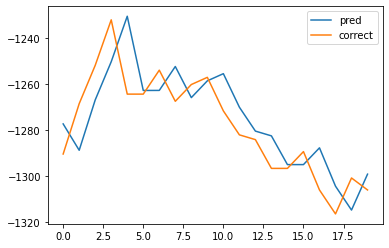

In [95]:
plt.plot(pred[0:20])
plt.plot(correct[:20])
plt.legend(['pred', 'correct'])

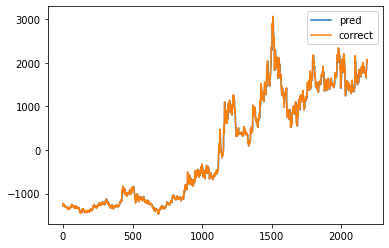

In [97]:
plt.plot(pred[:4000])
plt.plot(correct[:4000])
plt.legend(['pred', 'correct'])

In [70]:
len(pred)

0

In [66]:
len(correct)

2188